# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
from bs4 import BeautifulSoup
import re
from gensim.models import word2vec
import logging
import multiprocessing
from nltk.corpus import stopwords
from collections import Counter
# Download the punkt tokenizer for sentence splitting
import nltk.data
nltk.download('popular')   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def lyrics_to_wordlist(lyric, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #  
    # 1. Remove non-letters
    lyric_text = re.sub("[^a-zA-Z]"," ", lyric)
    #
    # 3. Convert words to lower case and split them
    words = lyric_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/Adam/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/Adam/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/Adam/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/Adam/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/Adam/nlt

In [2]:
# Read data from files and prepare data columns
lyrics_df = pd.read_csv("lyrics.csv")
# Drop columns without lyrics
lyrics_df = lyrics_df.dropna(subset=['lyrics'], axis=0)
# enforce lyrics as string
lyrics_df['lyrics'] = lyrics_df.lyrics.astype('str')
# apply lyrics_to_wordlist function in vectorized way
lyrics_df['lyrics_list'] = lyrics_df['lyrics'].apply(lyrics_to_wordlist, remove_stopwords=True)

In [3]:
lyrics_df.head()

,index,song,year,artist,genre,lyrics,lyrics_list
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...","[oh, baby, know, gonna, cut, right, chase, wom..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...","[playin, everything, easy, like, seem, sure, s..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,"[search, tenderness, hard, find, love, need, l..."
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...","[oh, oh, oh, oh, oh, oh, verse, wrote, book, s..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...","[party, people, people, party, popping, sittin..."


In [4]:
cores = multiprocessing.cpu_count()
print(cores)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = cores-1 # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
model_name = f"{num_features}features_{min_word_count}minwords_{context}context"

4


In [5]:
# Initialize and train the model (this will take some time)

print("Training model...")
model = word2vec.Word2Vec(lyrics_df['lyrics_list'].tolist(), workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model.save(model_name)

2020-04-14 12:09:59,074 : INFO : collecting all words and their counts
2020-04-14 12:09:59,075 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2020-04-14 12:09:59,940 : INFO : PROGRESS: at sentence #10000, processed 1147030 words, keeping 56164 word types
2020-04-14 12:10:00,464 : INFO : PROGRESS: at sentence #20000, processed 2369372 words, keeping 91682 word types
2020-04-14 12:10:00,994 : INFO : PROGRESS: at sentence #30000, processed 3538230 words, keeping 107963 word types
2020-04-14 12:10:01,713 : INFO : PROGRESS: at sentence #40000, processed 4799852 words, keeping 130265 word types
2020-04-14 12:10:02,227 : INFO : PROGRESS: at sentence #50000, processed 5939943 words, keeping 151445 word types
2020-04-14 12:10:02,745 : INFO : PROGRESS: at sentence #60000, processed 7172080 words, keeping 169102 word types
2020-04-14 12:10:03,260 : INFO : PROGRESS: at sentence #70000, processed 8313429 words, keeping 184275 word types
2020-04-14 12:10:03,806 : INFO : PROGRESS: at sentence #80000, processed 9500307 words, keeping 197297 word types
2020-04-14 12:10:04,530 : INFO : PROGRESS: at sentence #90000, processed 10810672 words, k

In [6]:
# model = word2vec.Word2Vec.load(model_name)

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [7]:
print(model.wv.most_similar(positive=["baby"]))
print(model.wv.most_similar(positive=["yeah"]))
print(model.wv.most_similar(positive=["twist"]))
print(model.wv.most_similar(negative=["love"]))
print(model.wv.most_similar(negative=["ooh"]))
print(model.wv.most_similar(negative=["ring"]))

[('girl', 0.6109623908996582), ('love', 0.574866533279419), ('babe', 0.56733238697052), ('cause', 0.5601931810379028), ('want', 0.5541319251060486), ('know', 0.5424745678901672), ('oh', 0.5332065224647522), ('lovin', 0.5264571905136108), ('honey', 0.5231078267097473), ('ooh', 0.5187228918075562)]
[('oh', 0.5872724056243896), ('baby', 0.5119950175285339), ('know', 0.4715331196784973), ('got', 0.4703831374645233), ('aw', 0.46435004472732544), ('eah', 0.46378862857818604), ('ooh', 0.46314921975135803), ('cause', 0.4585038125514984), ('get', 0.4294370412826538), ('right', 0.4283602237701416)]
[('watusi', 0.4429550766944885), ('gurlz', 0.4016619026660919), ('hips', 0.36936384439468384), ('flick', 0.35419002175331116), ('twists', 0.35115495324134827), ('fist', 0.3499768376350403), ('rebete', 0.34788694977760315), ('wiggle', 0.3381167948246002), ('wurr', 0.32221171259880066), ('twirl', 0.3181037902832031)]
[('panels', 0.5043876767158508), ('monte', 0.48525840044021606), ('clerks', 0.477102696

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [8]:
print(model.wv.similar_by_vector(model['tall'] - model['tan'], topn=5))
print(model.wv.similar_by_vector(model['tall'] + model['tan'], topn=5))
print(model.wv.similar_by_vector(model['rock'] - model['roll'] - model['drugs'], topn=5))
print(model.wv.similar_by_vector(model['spaghetti'] - model['italy'], topn=5))
print(model.wv.similar_by_vector(model['money'] + model['power'], topn=5))

[('tall', 0.6302306652069092), ('fall', 0.3698551058769226), ('still', 0.3234439492225647), ('taller', 0.308616578578949), ('wall', 0.30586570501327515)]
[('tall', 0.7764078974723816), ('tan', 0.7764078974723816), ('ipanema', 0.46277832984924316), ('taller', 0.4127580523490906), ('tanned', 0.3974989056587219)]
[('clo', 0.2627798020839691), ('ninastruggle', 0.26206138730049133), ('gd', 0.2589706778526306), ('rock', 0.2558306157588959), ('dita', 0.25252050161361694)]
[('spaghetti', 0.6384890079498291), ('stomach', 0.41545385122299194), ('rectum', 0.4098580479621887), ('eyeballs', 0.39229321479797363), ('itchin', 0.38766443729400635)]
[('money', 0.773374080657959), ('power', 0.773374080657959), ('cash', 0.4312385618686676), ('profit', 0.43032222986221313), ('currency', 0.42356887459754944)]


/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Adam/.pyenv/versions/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing 

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [9]:
# Loading the sentiment data into dataframe
pwd = %pwd
sent_df = pd.read_csv(f'{pwd}/SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt', sep='\t', 
                      header=None)
sent_df.columns = ['sentiment', 'word']

# Removing hashtags
sent_df['word'] = sent_df['word'].str.strip('#').str.strip()
sent_df.set_index('word', inplace=True)

# Creating label for use in logistic regression classifier
sent_df['label'] = -1
sent_df.loc[sent_df.sentiment >= 0, 'label'] = 1
print(sent_df.shape)

# Creating dataframe from model vocabulary word vectors
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()]
ordered_vocab = sorted(ordered_vocab, key=lambda k: k[2])
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
word_vectors = pd.DataFrame(model.wv.vectors[term_indices, :], index=ordered_terms)
print(word_vectors.shape)

# Joining word vector dataframe to sentiment dataframe
sentiment_vectors = sent_df.merge(word_vectors, left_index=True, right_index=True)
print(sentiment_vectors.shape)

# Creating datasets
y_class = sentiment_vectors['label'].values.reshape(-1)
y_reg = sentiment_vectors['sentiment'].values.reshape(-1)
print(y_class.shape)
X = sentiment_vectors.iloc[:,2:]
print(X.shape)
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.25)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.25)

(1515, 2)
(45511, 300)
(1015, 302)
(1015,)
(1015, 300)


In [10]:
# Training Logistic Regression classifier
logreg = LogisticRegression(random_state=42)
logreg.fit(X_class_train, y_class_train)

# Evaluating Logistic Regression classifier
y_class_pred = logreg.predict(X_class_test)
results = confusion_matrix(y_class_test, y_class_pred)
accuracy = (results[0,0] + results[1,1])/np.sum(results)
precision = results[1,1]/np.sum(results[:, 1])
recall = results[1,1]/np.sum(results[1,:])
print(f'Accuracy: {round(accuracy, 3)} \n Precision: {round(precision, 3)} \n Recall: {round(recall, 3)}')
print(classification_report(y_class_test, y_class_pred))

Accuracy: 0.819 
 Precision: 0.832 
 Recall: 0.866
              precision    recall  f1-score   support

          -1       0.80      0.75      0.77       105
           1       0.83      0.87      0.85       149

    accuracy                           0.82       254
   macro avg       0.82      0.81      0.81       254
weighted avg       0.82      0.82      0.82       254



In [11]:
# Training Ridge Regressor 
linreg = Ridge()
linreg.fit(X_reg_train, y_reg_train)

# Predicting continous sentiment values
y_reg_pred = linreg.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.1253671971108661


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [12]:
# Creating set of words what wasn't used in training
X_val = word_vectors.loc[~word_vectors.index.isin(sent_df.index)]

# Predicting sentiment values for Logistic and Ridge Regressions
y_class_val = logreg.predict_proba(X_val)
y_reg_val = linreg.predict(X_val)

# Creating dataframes for prediction results
class_val_df = pd.DataFrame(data=y_class_val, index=X_val.index, columns=['Negative', 'Positive'])
reg_val_df = pd.DataFrame(data=y_reg_val, index=X_val.index, columns=['Predicted'])

# Extracting top 20 positive and negative words for each regressor
top_20_pos_class = class_val_df.sort_values(by='Positive', ascending=False).index[:20].tolist()
top_20_neg_class = class_val_df.sort_values(by='Negative', ascending=False).index[:20].tolist()
print(f'Top 20 Positive Sentiment words Logistic Regression: \n {top_20_pos_class}')
print(f'Top 20 Negative Sentiment words Logistic Regression: \n {top_20_neg_class}')
top_20_pos_reg = reg_val_df.sort_values(by='Predicted', ascending=False).index[:20].tolist()
top_20_neg_reg = reg_val_df.sort_values(by='Predicted', ascending=True).index[:20].tolist()
print(f'Top 20 Positive Sentiment words Linear Regression: \n {top_20_pos_reg}')
print(f'Top 20 Negative Sentiment words Linear Regression: \n {top_20_neg_reg}')

Top 20 Positive Sentiment words Logistic Regression: 
 ['harmony', 'hawaii', 'chipmunks', 'abc', 'hospitality', 'starlight', 'cozy', 'gala', 'artie', 'strolling', 'marvellous', 'venus', 'heavenly', 'alvin', 'blaine', 'gifts', 'scott', 'special', 'jamaica', 'together']
Top 20 Negative Sentiment words Logistic Regression: 
 ['callous', 'sickened', 'beaten', 'senseless', 'maimed', 'victimized', 'raped', 'carcass', 'writhing', 'torturing', 'tortured', 'soulless', 'bleeding', 'spineless', 'faceless', 'wretched', 'diseased', 'bruised', 'feeble', 'bloodstains']
Top 20 Positive Sentiment words Linear Regression: 
 ['grateful', 'cozy', 'kindly', 'marvellous', 'harmony', 'bright', 'frutti', 'gifts', 'cosy', 'sparkle', 'strolling', 'loveliness', 'starlight', 'barbra', 'gala', 'joys', 'decimals', 'sparkling', 'snuggled', 'brighter']
Top 20 Negative Sentiment words Linear Regression: 
 ['callous', 'soulless', 'sickened', 'senseless', 'unbeliever', 'spineless', 'raped', 'torture', 'torturing', 'bloo

Both Ridge and Logistic Regression (with class probability as output) produce good and similar top20 positive and negative words.

The results make pretty good sense, both for the positive and negative words. The positive words are slightly more obscure, for example the inclusion of several names such as "gabriella", "artie" and "ethel" in the Logistic Regression predictions aren't entirely understandable, but it might be because they are from songs with other strongly positive word sentiments. The inclusion of "abc" is very interesting and could be a mistake for a different dataset, but given that we're dealing with lyrics it actually shines a light on what's happening. ABC is the name of an infectuosly positive and happy Jackson 5 song. It is  included in the dataset twice as a cover, although only appears as a token for one of them (American Juniors version). It also appears as a word in the Chris Brown song "abc" which also has positive-seeming words, so the otherwise valence-free token "abc" gets a very positive sentiment due to it only co-occuring with other positive words

In [13]:
print(lyrics_df.loc[lyrics_df.song == 'abc']['lyrics_list'][120396])
print(lyrics_df.loc[lyrics_df.song == 'abc']['lyrics_list'][233810])
lyrics_df.loc[lyrics_df.song == 'abc']

['hahaha', 'ya', 'wanna', 'learn', 'ya', 'abcs', 'b', 'c', 'haha', 'x', 'ya', 'gon', 'like', 'right', 'yeahhh', 'oh', 'abc', 'x', 'many', 'ways', 'spell', 'love', 'one', 'way', 'show', 'one', 'way', 'show', 'scare', 'mountain', 'yell', 'til', 'face', 'turns', 'blue', 'come', 'back', 'prove', 'prove', 'pre', 'chorus', 'would', 'rather', 'let', 'day', 'day', 'actions', 'speak', 'louder', 'say', 'pick', 'letters', 'alphabetbet', 'would', 'say', 'way', 'chorus', 'maybe', 'b', 'something', 'c', 'e', 'f', 'initely', 'know', 'want', 'g', 'take', 'hi', 'higher', 'j', 'tryna', 'say', 'love', 'simple', 'b', 'c', 'gotta', 'sing', 'since', 'made', 'clear', 'understand', 'wanna', 'wanna', 'know', 'cool', 'cool', 'girl', 'would', 'hurt', 'said', 'know', 'cause', 'p', 'q', 'x', 'ed', 'rest', 'man', 'got', 'eyes', 'u', 'baby', 'pre', 'chorus', 'would', 'rather', 'let', 'day', 'day', 'actions', 'speak', 'louder', 'say', 'pick', 'letters', 'alphabetbet', 'would', 'say', 'way', 'chorus', 'maybe', 'b', 's

,index,song,year,artist,genre,lyrics,lyrics_list
113962,113962,abc,2011,glee,Not Available,A buh-buh buh buh-buh\nA buh-buh buh buh-buh\n...,"[buh, buh, buh, buh, buh, buh, buh, buh, buh, ..."
120396,120396,abc,2009,chris-brown,Hip-Hop,Hahaha...\nYa'll Wanna Learn Ya'll ABCs...\nA....,"[hahaha, ya, wanna, learn, ya, abcs, b, c, hah..."
143598,143598,abc,2015,cody-simpson,Pop,"I'm usually a yes man, I always say yes man\nW...","[usually, yes, man, always, say, yes, man, wal..."
233810,233810,abc,2004,american-juniors,Pop,A buh-buh buh buh-buh\nA buh-buh buh buh-buh\n...,"[buh, buh, buh, buh, buh, buh, buh, buh, buh, ..."


### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [14]:
# Creating Counter object to access most_common() method and get 3000 most common words
word_counts = Counter()
for l in lyrics_df['lyrics_list'].tolist():
    word_counts.update(l)
top_3000 = {e[0]: e[1] for e in word_counts.most_common(3000)}

In [15]:
# Creating Counter object with counts of words per genre
genres = {}
for genre in lyrics_df.genre.unique():
    genres[genre] = Counter()
    g = lyrics_df.loc[lyrics_df.genre == genre]['lyrics_list'].tolist()
    for l in g:
        genres[genre].update(l)

In [16]:
# Creating dictionary to hold relative frequency of words per genres
genre_freqs = {}
for genre, genre_counter in genres.items():
    freq_dict = {}
    vocab_size = sum(word_counts.values())
    genre_vocab_size = sum(genre_counter.values())
    for word, count in top_3000.items():
        corpus_freq = count / vocab_size
        genre_freq = genre_counter[word] / genre_vocab_size
        freq_dict[word] = genre_freq / corpus_freq
    genre_freqs[genre] = {k: v for k, v in sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)}

In [17]:
# get top 50 words per genre
top_50 = []
top_50_dict = {genre: list(d.keys())[:50] for genre, d in genre_freqs.items()}
top_50 = []
for d in top_50_dict.values():
    top_50 += d 
len(top_50)

600

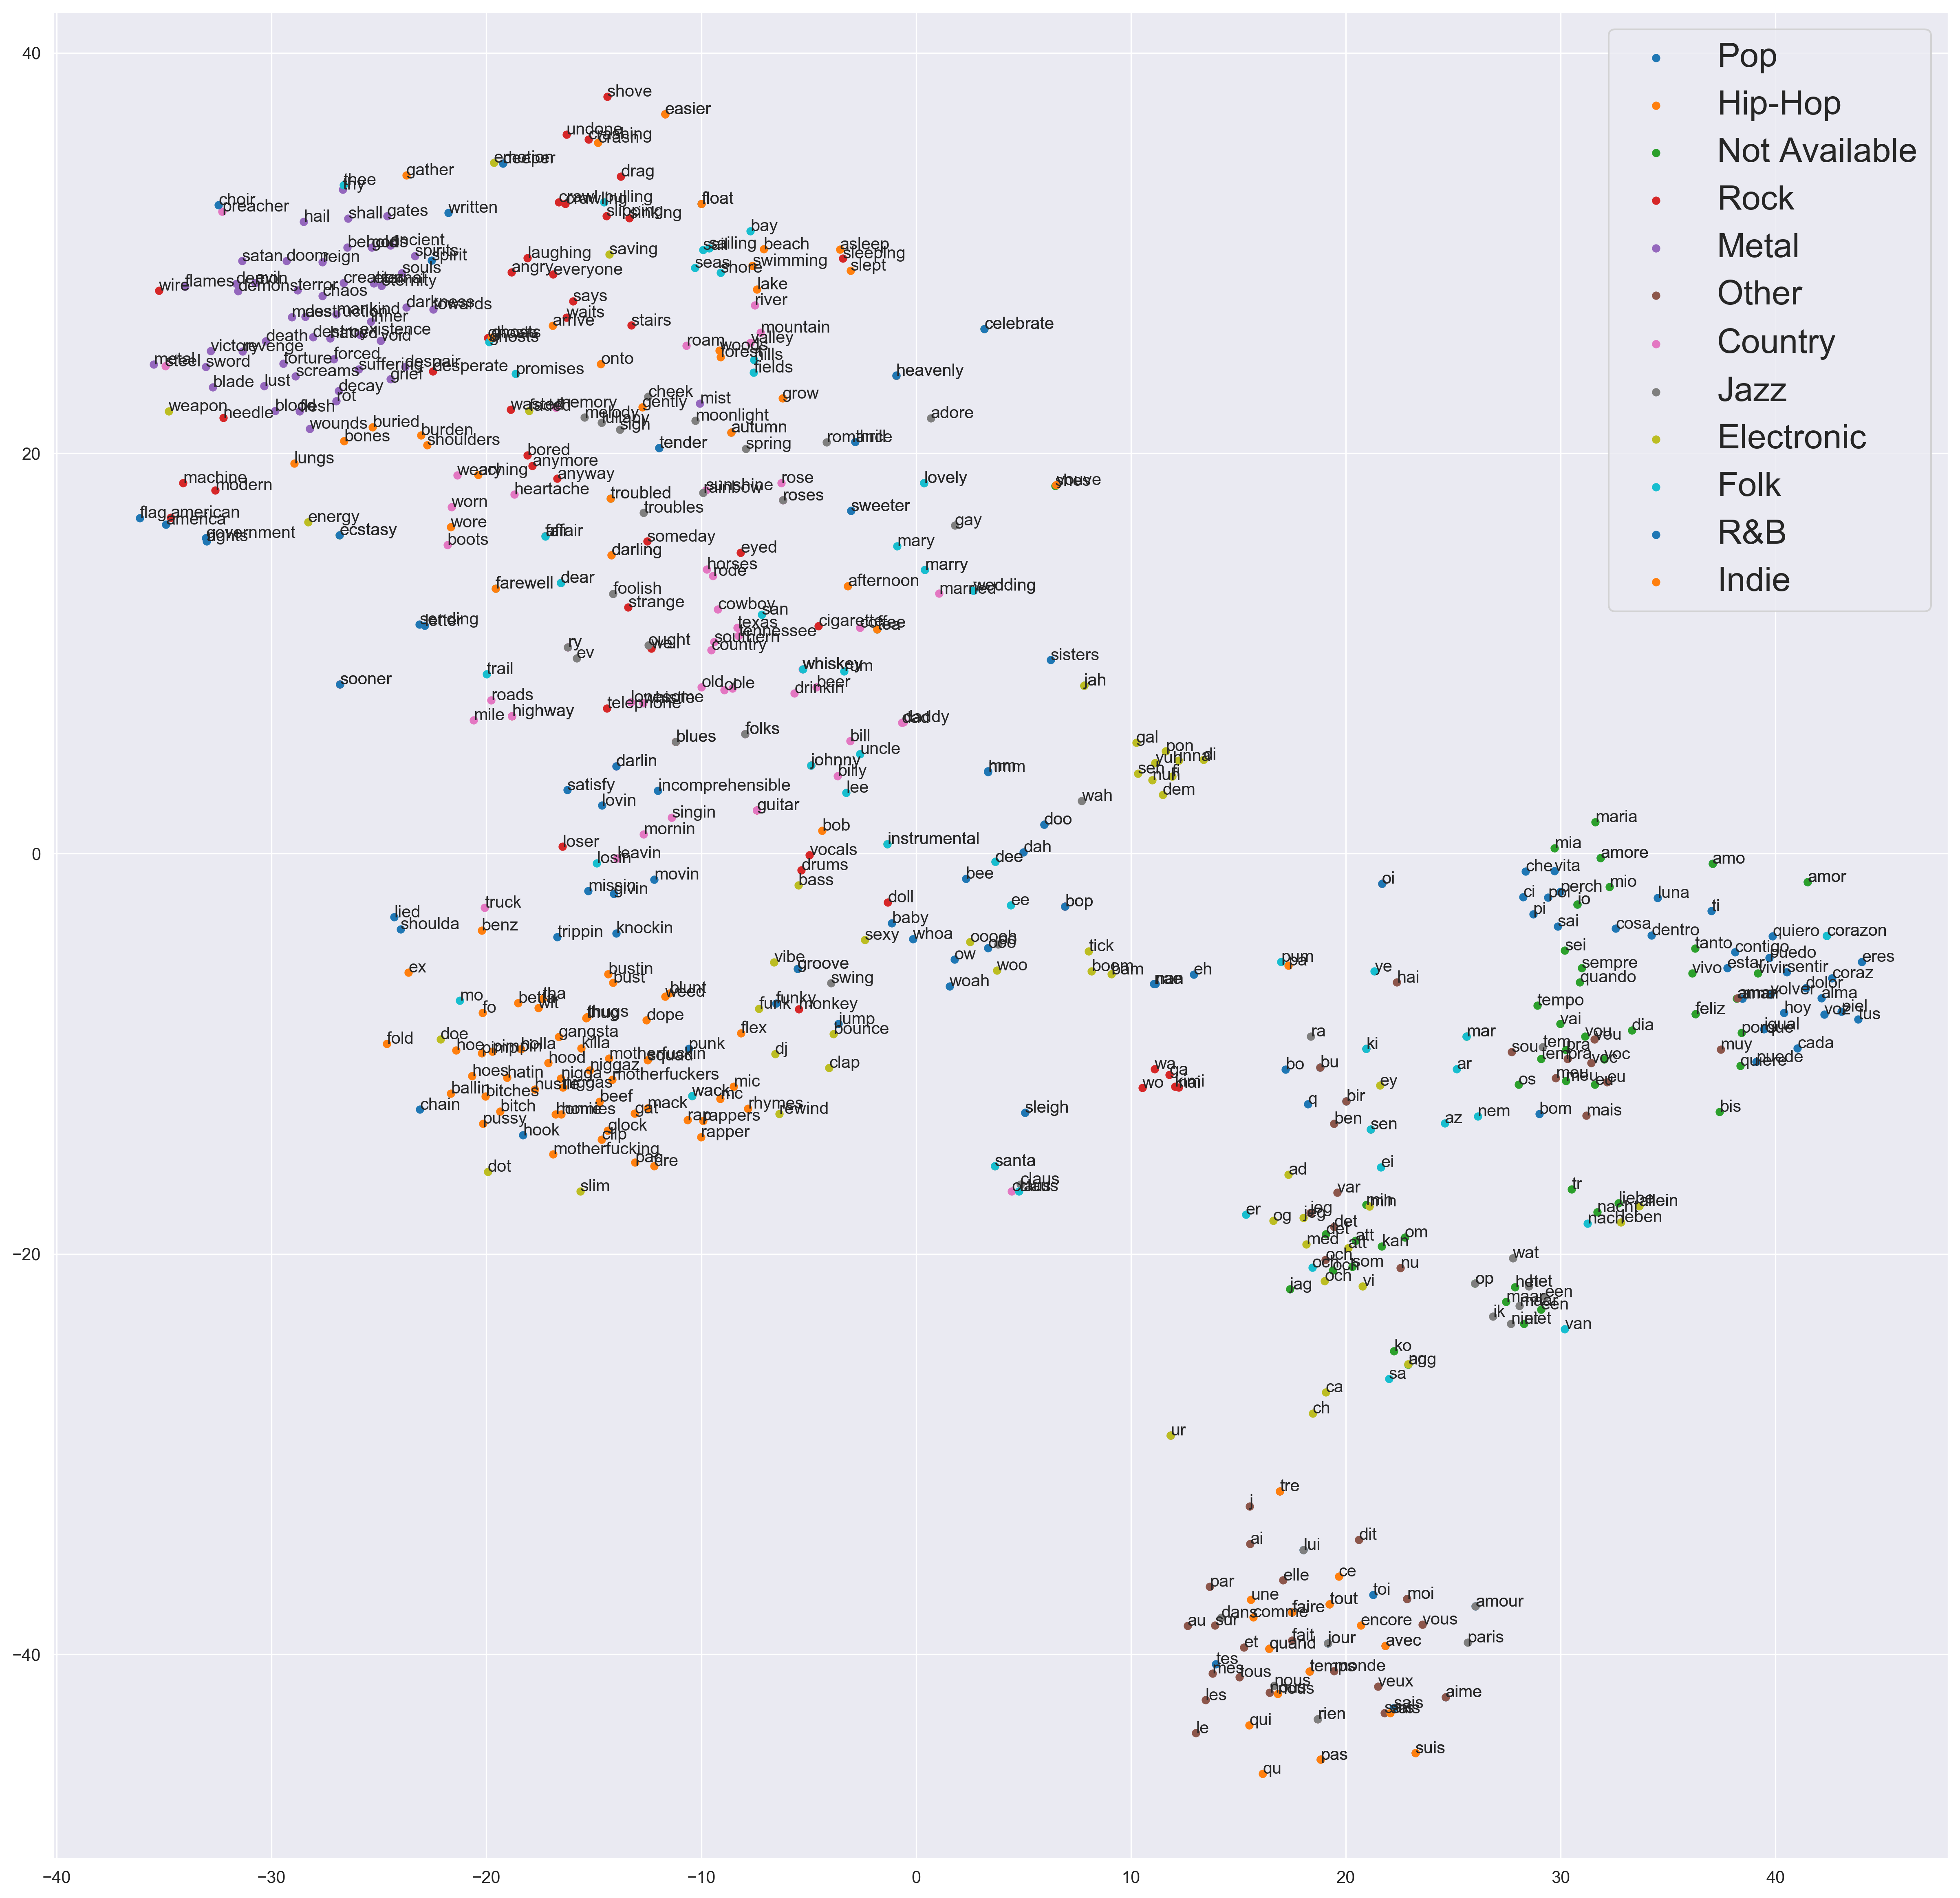

In [18]:
# Get word vectors for top 50 words per genre
X = model.wv[top_50]

# Reduce all top_50 300 dimensional embeddings to 2 dimensional with TSNE 
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
idxs = 0
fig = plt.figure(figsize=(20, 20), dpi=300)
ax = fig.add_subplot(1, 1, 1)
# iteratively create dataframes with each genres word embeddings and then plot with annotations  
for genre, vocab in top_50_dict.items():
    idx = pd.MultiIndex.from_product([[genre],vocab])
    df = pd.DataFrame(X_tsne[idxs:idxs+len(vocab), :], index=idx, columns=['x', 'y'])
    idxs += len(vocab)
#     tsne_df.append(df)
    ax.scatter('x', 'y', cmap='prism', data=df, s=15, label=genre)
    for word, row in df.iterrows():
        ax.annotate(f'{word[1]}', (row['x'], row['y']), size='medium')
plt.legend(scatterpoints=1, fontsize=20)
plt.show();

This plot shows that different genres have varying levels of tightness of clustering. Metal and Hip-Hop form very distinct and tight clusters.

Hip-Hop is intermingled with top R&B and Electronic word embeddings. Those two genres have a looser cluster structure but appear to be closer to each other than to any other genres.

Metal is similarly neighbored/surrounded by Rock and Indie, while Country resides almost inbetween Metal and Hip-Hop, occupying its own distinct space.

There are two or three other cluster areas that aren't well defined by genre. In fact, they are better defined by language, as we see a cluster of french, spanish and german/dutch words. This suggests that to get a better visualization result it would be better to create different plots for the different languages. Unfortunately there isn't a column for "language" in the original dataset, so to create a language-specific visualization we'd have to enrich the data with that label. 

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [19]:
# inspect prior probabilites/data distribution
class_prior = lyrics_df.groupby('genre').size() / len(lyrics_df)
print(class_prior)

genre
Country          0.053973
Electronic       0.029885
Folk             0.008415
Hip-Hop          0.093226
Indie            0.011814
Jazz             0.029904
Metal            0.089133
Not Available    0.089816
Other            0.019467
Pop              0.151810
R&B              0.012759
Rock             0.409800
dtype: float64


In [20]:
# rejoin lyrics for compatability with sklearn vectorizers
lyrics_joined = lyrics_df['lyrics_list'].str.join(' ')

# Create Count and TFIDF vectorizers
vectorizer = CountVectorizer(analyzer="word", tokenizer = None, preprocessor=None,
                             stop_words = None, max_features = 5000)

tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer = None, preprocessor=None,
                                   stop_words = None, max_features = 5000)

# split data
train_lyrics, test_lyrics, train_genre, test_genre = train_test_split(lyrics_joined, 
                                                                      lyrics_df['genre'], 
                                                                      test_size=0.25)
# transform training data
train_data_vector = vectorizer.fit_transform(train_lyrics)
train_data_tfidf = tfidf_vectorizer.fit_transform(train_lyrics)

In [21]:
# fitting Complement Naive Bayes classifier which is better suited for text classification
clf_vector = ComplementNB().fit(train_data_vector.toarray(), train_genre)
vec_genre_pred = clf_vector.predict(vectorizer.transform(test_lyrics).toarray())

Show the confusion matrix.

In [22]:
results = confusion_matrix(test_genre, vec_genre_pred)
accuracy = np.trace(results) /np.sum(results)
print(f'Accuracy: {round(accuracy, 3)}')
print(results)

Accuracy: 0.469
[[  136     0     0   254     0     3   108    13     0   106     0  2950]
 [   10     7     0   365     0     0   205    54     0   210     0  1124]
 [   10     0     4    42     0     2    59    30     3    59     0   360]
 [   10     0     0  5039     0     1   112    77     0   403     1   581]
 [    4     0     0    56     0     1    25     9     0    48     0   617]
 [   28     0     0   177     0    17    89    50     0   212     0  1320]
 [   21     2     0   481     0     1  2902   147     2   147     0  2251]
 [  186     1     1   822     0     3   442   556     0  1089     3  2838]
 [   12     0     0   209     0     3    61   104     3   233     0   655]
 [   72     4     1  1190     0     8   289   222     6  2174     0  6211]
 [    5     0     0   131     0     0    31     5     0   113     1   568]
 [  287     2    11  2941     0    17  1673   413    14  1638     2 20445]]


Show the classification report - precision, recall, f1 for each class.

In [23]:
print(classification_report(test_genre, vec_genre_pred))

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      Country       0.17      0.04      0.06      3570
   Electronic       0.44      0.00      0.01      1975
         Folk       0.24      0.01      0.01       569
      Hip-Hop       0.43      0.81      0.56      6224
        Indie       0.00      0.00      0.00       760
         Jazz       0.30      0.01      0.02      1893
        Metal       0.48      0.49      0.49      5954
Not Available       0.33      0.09      0.15      5941
        Other       0.11      0.00      0.00      1280
          Pop       0.34      0.21      0.26     10177
          R&B       0.14      0.00      0.00       854
         Rock       0.51      0.74      0.61     27443

     accuracy                           0.47     66640
    macro avg       0.29      0.20      0.18     66640
 weighted avg       0.41      0.47      0.40     66640



In [24]:
clf_tfidf = ComplementNB().fit(train_data_tfidf.toarray(), train_genre)
# test_vector = tfidf_vectorizer.transform(test_lyrics)
tfidf_genre_pred = clf_tfidf.predict(tfidf_vectorizer.transform(test_lyrics).toarray())

In [25]:
results = confusion_matrix(test_genre, tfidf_genre_pred)
accuracy = np.trace(results) /np.sum(results)
print(f'Accuracy: {round(accuracy, 3)}')
print(results)

Accuracy: 0.456
[[  563     0     0   304     0    17   229    36     1   116     0  2304]
 [   19     3     0   370     0     6   350    90     0   203     0   934]
 [   34     0    17    37     0     3   110    55     0    32     0   281]
 [   21     0     1  5039     0     2   187   314     0   240     0   420]
 [    8     0     0    60     1     4    66    21     0    38     0   562]
 [  138     0     0   215     0   126   174   104     2   194     0   940]
 [   29     0     0   381     0     3  3839   278     0   103     0  1321]
 [  295     0     2   836     0    17   717   994     3   829     0  2248]
 [   36     0     0   221     0    30   117   193     1   154     0   528]
 [  222     3     2  1301     1    65   646   645     3  1950     0  5339]
 [   29     0     0   151     0    10    70     9     0   117     0   468]
 [  685     2    19  2889     0    93  3450  1107     9  1345     0 17844]]


In [26]:
print(classification_report(test_genre, tfidf_genre_pred))

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      Country       0.27      0.16      0.20      3570
   Electronic       0.38      0.00      0.00      1975
         Folk       0.41      0.03      0.06       569
      Hip-Hop       0.43      0.81      0.56      6224
        Indie       0.50      0.00      0.00       760
         Jazz       0.34      0.07      0.11      1893
        Metal       0.39      0.64      0.48      5954
Not Available       0.26      0.17      0.20      5941
        Other       0.05      0.00      0.00      1280
          Pop       0.37      0.19      0.25     10177
          R&B       0.00      0.00      0.00       854
         Rock       0.54      0.65      0.59     27443

     accuracy                           0.46     66640
    macro avg       0.33      0.23      0.20     66640
 weighted avg       0.42      0.46      0.41     66640



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [27]:
# create vocabulary set for faster check
vocab = set(model.wv.vocab.keys())
# create empty vectors to house average word vectors
lyric_vectors = np.zeros((len(lyrics_df), word_vectors.shape[1]))
lyric_tfidf_vectors = np.zeros((len(lyrics_df), word_vectors.shape[1]))

# create both average and idf-weighted average vectors for each song
for i, lyric_list in enumerate(lyrics_df['lyrics_list']):
    max_idf = max(tfidf_vectorizer.idf_)
    lyric_list = [l for l in lyric_list if l in vocab]
    if lyric_list:
        song_embeddings = model.wv[lyric_list]
        idf_idxs = [tfidf_vectorizer.vocabulary_.get(l, max_idf) for l in lyric_list]
        idfs = tfidf_vectorizer.idf_.take(idf_idxs).reshape(-1,1)
        tfidf_embeddings = np.multiply(song_embeddings, idfs)
        lyric_vectors[i] = song_embeddings.mean(axis=0)
        lyric_tfidf_vectors[i] = tfidf_embeddings.mean(axis=0)
    else:
        continue

In [28]:
# splitting data and training Logistic Regression classifier
train_avg_vector, test_avg_vector, train_genre, test_genre = train_test_split(lyric_vectors, 
                                                                              lyrics_df['genre'], 
                                                                              test_size=0.25)
clf_avg_vector = LogisticRegression().fit(train_avg_vector, train_genre)
avg_vec_genre_pred = clf_avg_vector.predict(test_avg_vector)
results = confusion_matrix(test_genre, avg_vec_genre_pred)
accuracy = np.trace(results) /np.sum(results)
print(f'Accuracy: {round(accuracy, 3)}')
print(results)
print(classification_report(test_genre, avg_vec_genre_pred))

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.511
[[  385     0     0    15     0    41    14    30     0   169     0  2968]
 [   12     8     0   158     0     4    90    35     0   284     0  1454]
 [   15     0     3     8     0     6    16    21     0    40     0   463]
 [    3     1     0  4111     0     3    37    84     0   403     0  1553]
 [    5     0     0     9     0     0     5     5     0    52     0   735]
 [  121     0     0    47     0   126    11    60     0   261     0  1442]
 [    4    10     0   133     0     6  2767    67     0    88     0  2851]
 [   76     1     1   305     0    30   207   496     0   985     0  3736]
 [   32     0     0   141     0    32    28    84     0   247     0   786]
 [   85     9     0   449     0    55   111   253     0  2350     0  6810]
 [   21     0     0    49     0     6    15     5     0   157     0   625]
 [  275     2     4   373     0    82   831   373     0  1470     0 23804]]


/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      Country       0.37      0.11      0.17      3622
   Electronic       0.26      0.00      0.01      2045
         Folk       0.38      0.01      0.01       572
      Hip-Hop       0.71      0.66      0.69      6195
        Indie       0.00      0.00      0.00       811
         Jazz       0.32      0.06      0.10      2068
        Metal       0.67      0.47      0.55      5926
Not Available       0.33      0.08      0.13      5837
        Other       0.00      0.00      0.00      1350
          Pop       0.36      0.23      0.28     10122
          R&B       0.00      0.00      0.00       878
         Rock       0.50      0.87      0.64     27214

     accuracy                           0.51     66640
    macro avg       0.32      0.21      0.21     66640
 weighted avg       0.46      0.51      0.44     66640



#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [29]:
# splitting data and training Logistic Regression classifier
train_tfidf_vector, test_tfidf_vector, train_genre, test_genre = train_test_split(lyric_tfidf_vectors, 
                                                                                  lyrics_df['genre'], 
                                                                                  test_size=0.25)
clf_tfidf_vector = LogisticRegression().fit(train_tfidf_vector, train_genre)
tfidf_vec_genre_pred = clf_tfidf_vector.predict(test_tfidf_vector)
results = confusion_matrix(test_genre, tfidf_vec_genre_pred)
accuracy = np.trace(results) /np.sum(results)
print(f'Accuracy: {round(accuracy, 3)}')
print(results)
print(classification_report(test_genre, tfidf_vec_genre_pred))

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.518
[[  608     0     2    13     0    68    18    22     2   187     1  2714]
 [   14    27     1   114     0     9    89    47     1   253     0  1426]
 [   21     3    29     3     0     6    19    26     0    29     0   419]
 [   11     7     0  4170     0     5    29    85     1   377     0  1574]
 [    4     0     0    11     0     5     5     8     0    49     0   733]
 [  125     0     2    33     0   224     8    61     1   257     1  1270]
 [    4     6     0   147     1     2  2893    83     1    83     0  2788]
 [  100     7    17   290     1    33   200   633     6   958     0  3739]
 [   22     0     0   117     0    42    31   113     4   200     0   731]
 [  141    20     3   436     0    79   112   320     8  2296     0  6627]
 [   16     0     0    33     0     8    18     7     0   144     1   669]
 [  384    23    15   390     2   125   836   430     6  1378     2 23632]]
               precision    recall  f1-score   support

      Country       0.42   

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [69]:
class CnnTextClassifier(nn.Module):
    def __init__(self, weights, emb_size, num_classes, num_filters, window_sizes=(3, 4, 5), freeze_embeddings=True):
        super(CnnTextClassifier, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(weights, freeze=freeze_embeddings)

        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, [window_size, emb_size], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(num_filters * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x)           # [B, T, E]

        # Apply a convolution + max pool layer for each window size
        x = torch.unsqueeze(x, 1)       # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))        # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)            # [B, F, window]

        # Dropout
        x = self.dropout(x)
        
        # FC
        x = x.view(x.size(0), -1)       # [B, F * window]
        logits = self.fc(x)             # [B, class]
        
        # Prediction
        probs = F.softmax(logits, dim=-1)       # [B, class]
        classes = torch.max(probs, 1)[1]# [B]

        return probs, classes

In [70]:
output_size = len(lyrics_df.genre.unique())
kernel_heights = [3, 4, 5, 6, 7, 8, 9, 10] 
keep_probab = 0.7 
vocab = set(model.wv.vocab.keys())
vocab_size = len(vocab)
embedding_length = model.wv.vectors.shape[1]
weights = torch.FloatTensor(model.wv.vectors)

net = CnnTextClassifier(weights=weights, emb_size=embedding_length, num_classes=output_size, 
                        num_filters=embedding_length, window_sizes=kernel_heights, 
                        freeze_embeddings=True)

In [57]:
# turning genre labels into index numbers for softmax loss
n_words = 128
y = torch.from_numpy(lyrics_df.genre.factorize()[0])
# removing out of vocabulary tokens and padding tokens
X = lyrics_df.lyrics_list.apply(lambda x: [model.wv.vocab[token].index for token in x if token in vocab])
X = X.apply(lambda x: x[:n_words] + [0]*(n_words-len(x)))

In [71]:
# splitting data and ensuring proper shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [75]:
sample = 20000
val_sample = 5000
X_train, y_train = X_train[:sample], y_train[:sample]
X_test, y_test = X_test[:val_sample], y_test[:val_sample]
net.to('cpu')
optim = torch.optim.Adam(net.parameters())
loss_function = nn.CrossEntropyLoss()
epochs = 1
batch_size = 50
train_losses = {}
train_accs = {}
val_losses = {}
eval_accs = {}
batch_count = 0
for e in range(epochs):
    net.train()
    running_loss = 0
    for i in range(0, len(X_train), batch_size):
        net.train()
        batch = torch.LongTensor(np.vstack(X_train[i:i+batch_size].values))
#         idxs = torch.LongTensor([model.wv.vocab[token].index for token in tokens if token in vocab]).reshape(1,-1)
        y_pred, classes = net(batch)
        # Backpropagation
        optim.zero_grad()
        labels = y_train[i:i+batch_size]
        loss = loss_function(y_pred, labels)# create label that is a tensor with dims (1, num_classes) indicating the right genre 
        loss.backward()
        optim.step()
        train_accuracy = (classes==labels).sum().item()/batch_size
        running_loss += loss.item()
        batch_count += batch_size
        if batch_count % 1000 == 0:
            train_losses[batch_count] = running_loss/batch_count
            train_accs[batch_count] = train_accuracy 
            net.eval()
            eval_losses = 0
            acc = []
            for j in range(0, len(X_test), batch_size):
                with torch.no_grad():
                    eval_batch = torch.LongTensor(np.vstack(X_test[j:j+batch_size].values))
                    val_pred, val_classes = net(eval_batch)
                    val_labels = y_test[j:j+batch_size]
                    eval_loss = loss_function(val_pred, val_labels) # create label that is a tensor with dims (1, num_classes) indicating the right genre 
                    acc.append((val_classes==val_labels).sum().item()/batch_size)
                    eval_losses += eval_loss.item()
            val_losses[batch_count] = eval_losses/len(X_test)
            eval_accs[batch_count] = np.mean(acc)
            running_loss = 0
            print(f'Last Average Train loss: {train_losses[batch_count]}')
            print(f'Last Average Validation loss: {val_losses[batch_count]}')

Last Average Train loss: 0.045027459383010865
Last Average Validation loss: 0.04430114917755127
Last Average Train loss: 0.022011139392852784
Last Average Validation loss: 0.04428319773674011
Last Average Train loss: 0.014853906393051147
Last Average Validation loss: 0.044272352361679077
Last Average Train loss: 0.01094079887866974
Last Average Validation loss: 0.044290401792526246
Last Average Train loss: 0.008832872009277343
Last Average Validation loss: 0.0442730863571167
Last Average Train loss: 0.007402715484301249
Last Average Validation loss: 0.044272622632980346
Last Average Train loss: 0.006357391459601266
Last Average Validation loss: 0.04427782158851624
Last Average Train loss: 0.0055451240241527555
Last Average Validation loss: 0.04427110948562622
Last Average Train loss: 0.004877071513070001
Last Average Validation loss: 0.04426818146705627
Last Average Train loss: 0.004436988306045532
Last Average Validation loss: 0.04425781512260437
Last Average Train loss: 0.00398052772

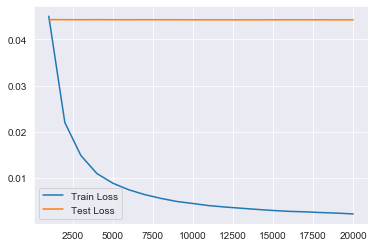

In [76]:
plt.plot(list(train_losses.keys()), list(train_losses.values()), label='Train Loss')
plt.plot(list(val_losses.keys()), list(val_losses.values()), label='Test Loss')
plt.legend()
plt.show()

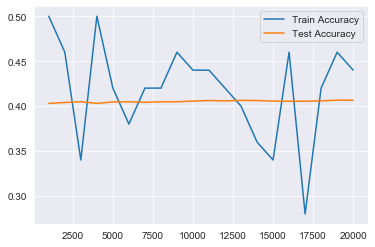

In [77]:
plt.plot(list(train_accs.keys()), list(train_accs.values()), label='Train Accuracy')
plt.plot(list(eval_accs.keys()), list(eval_accs.values()), label='Test Accuracy')
plt.legend()
plt.show();

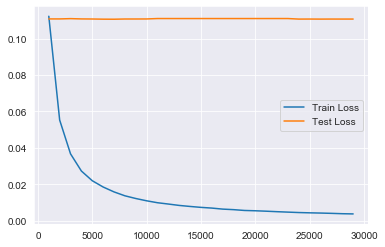

In [68]:
plt.plot(list(train_losses.keys()), list(train_losses.values()), label='Train Loss')
plt.plot(list(val_losses.keys()), list(val_losses.values()), label='Test Loss')
plt.legend()
plt.show()

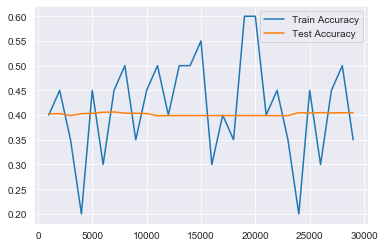

In [66]:
plt.plot(list(train_accs.keys()), list(train_accs.values()), label='Train Accuracy')
plt.plot(list(eval_accs.keys()), list(eval_accs.values()), label='Test Accuracy')
plt.legend()
plt.show();

For some reason the train and test losses don't converge and accuracy doesn't improve, although the training loss decreases quite nicely.
